In [1]:
# mac run: source env/bin/activate
# windows run: env\Scripts\activate

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap, HeatMapWithTime
from IPython.display import display

# Tasks
1. Calculate the PSPS Probability for each Weather Station.
2. a. Visualize the Weather Station wind speed distributions against its wind speed threshold,<br>
   b. and displaying its calculated PSPS Probability.

## Questions
1. What weather stations may have more of a bias in their PSPS probability assessment due to a limited amount of wind day datapoints? Any ideas on how you would handle this bias?
-     Note: no need to correct for it, just brainstorm for a version 2 of the model down the line
2. Anything interesting or challenging you encountered during the process or from looking at the results? Any ideas come to mind that maybe weren't part of the task at hand yet could be of interest?

### Merge in Datasets

In [2]:
# load in and merge all 3 datasets

weatherstation = pd.read_csv('data/gis_weatherstation_shape_2024_10_04.csv')
weatherstation['geometry'] = weatherstation.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf_weatherstation = gpd.GeoDataFrame(weatherstation, geometry='geometry')
gdf_weatherstation.crs = 'EPSG:4326'
gdf_weatherstation = gdf_weatherstation.to_crs(epsg=4326)

meteorology_summary = pd.read_csv('data/src_wings_meteorology_station_summary_snapshot_2023_08_02.csv')

meteorology_windspeed = pd.read_csv('data/src_wings_meteorology_windspeed_snapshot_2023_08_02.csv')

merged_df = meteorology_windspeed.merge(meteorology_summary, on='station', how='inner')
gdf_weatherstation_merged = merged_df.merge(gdf_weatherstation, left_on='station', right_on='weatherstationcode', how='inner')
gdf_weatherstation_merged.head()

date  wind_speed station snapshot_date_x vri  alert  max_gust  99th  \
0   9/14/2012        19.0     AMO        8/2/2023   H     35        40    32   
1   9/15/2012        20.0     AMO        8/2/2023   H     35        40    32   
2  10/14/2012        16.0     AMO        8/2/2023   H     35        40    32   
3  10/26/2012        23.0     AMO        8/2/2023   H     35        40    32   
4  10/27/2012        15.0     AMO        8/2/2023   H     35        40    32   

   95th snapshot_date_y  ...  twinguid hftd zone1idc  hftdidc  \
0    24      2023-08-02  ...       NaN    2        N        Y   
1    24      2023-08-02  ...       NaN    2        N        Y   
2    24      2023-08-02  ...       NaN    2        N        Y   
3    24      2023-08-02  ...       NaN    2        N        Y   
4    24      2023-08-02  ...       NaN    2        N        Y   

  gdb_geomattr_data                                globalid  \
0               NaN  {90874863-3E3A-4D88-A597-C531DBEE6E90}   
1               NaN  {90874863-3E3A-4D88-A597-C531DBEE6E90}   
2               NaN  {90874863-3E3A-4D88-A597-C531DBEE6E90}   
3               NaN  {90874863-3E3A-4D88-A597-C531DBEE6E90}   
4               NaN  {90874863-3E3A-4D88-A597-C531DBEE6E90}   

                                shape shape_srid snapshot_date  \
0  POINT (1556019.1347 12109260.1389)       4431     10/4/2024   
1  POINT (1556019.1347 12109260.1389)       4431     10/4/2024   
2  POINT (1556019.1347 12109260.1389)       4431     10/4/2024   
3  POINT (1556019.1347 12109260.1389)       4431     10/4/2024   
4  POINT (1556019.1347 12109260.1389)       4431     10/4/2024   

                     geometry  
0  POINT (-117.2765 33.35712)  
1  POINT (-117.2765 33.35712)  
2  POINT (-117.2765 33.35712)  
3  POINT (-117.2765 33.35712)  
4  POINT (-117.2765 33.35712)  

[5 rows x 38 columns]

### Wind Speed Summary Statistics for Each Station

In [3]:
wind_speed_stats = gdf_weatherstation_merged.groupby('station')['wind_speed'].agg(['count', 
                                                                                   'mean', 
                                                                                   'median', 
                                                                                   'min', 
                                                                                   'max', 
                                                                                   ('25th percentile', lambda x: x.quantile(0.25)),
                                                                                   ('75th percentile', lambda x: x.quantile(0.75))])
wind_speed_stats

count       mean  median   min   max  25th percentile  \
station                                                          
AMO        166  19.096386    18.0   9.0  40.0             15.0   
ANE        179  19.044693    18.0   7.0  43.0             14.0   
ARH        179  25.396648    25.0   9.0  46.0             20.0   
AVO        179  19.687151    18.0  10.0  45.0             15.0   
AVY        116  33.853448    32.0   9.0  62.0             24.0   
...        ...        ...     ...   ...   ...              ...   
WST         61  32.327869    33.0  10.0  51.0             28.0   
WSY        176  38.755682    38.0   7.0  75.0             31.0   
WWY        179  33.815642    33.0  16.0  56.0             29.0   
WYN        178  35.140449    35.0  18.0  54.0             31.0   
YSA        179  30.888268    31.0  16.0  54.0             26.0   

         75th percentile  
station                   
AMO                 22.0  
ANE                 23.5  
ARH                 31.0  
AVO                 23.0  
AVY                 42.0  
...                  ...  
WST                 38.0  
WSY                 45.0  
WWY                 38.0  
WYN                 39.0  
YSA                 36.0  

[215 rows x 7 columns]

### Question 1: 
What weather stations may have more of a bias in their PSPS probability assessment due to a limited amount of wind day datapoints? Any ideas on how you would handle this bias?
-     Note: no need to correct for it, just brainstorm for a version 2 of the model down the line

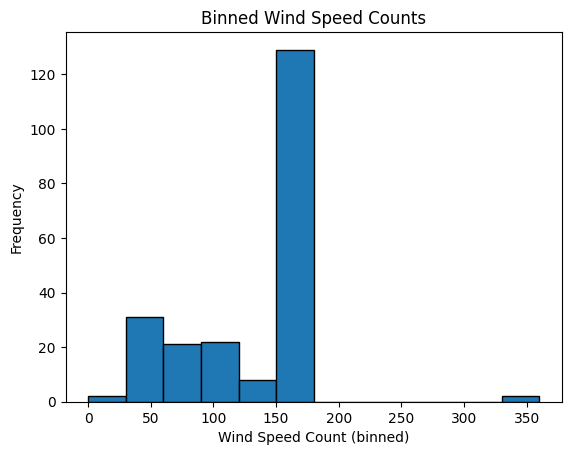

In [4]:
bin_edges = [30*x for x in range (13)]
binned_counts = np.histogram(wind_speed_stats['count'], bins=bin_edges)

plt.bar(binned_counts[1][:-1], binned_counts[0], width=np.diff(binned_counts[1]), align="edge", edgecolor="black")
plt.title('Binned Wind Speed Counts')
plt.xlabel('Wind Speed Count (binned)')
plt.ylabel('Frequency')
plt.show()

Awesome! Lets take a closer look at the counts of each bar to get a concrete number on how many are in each bar

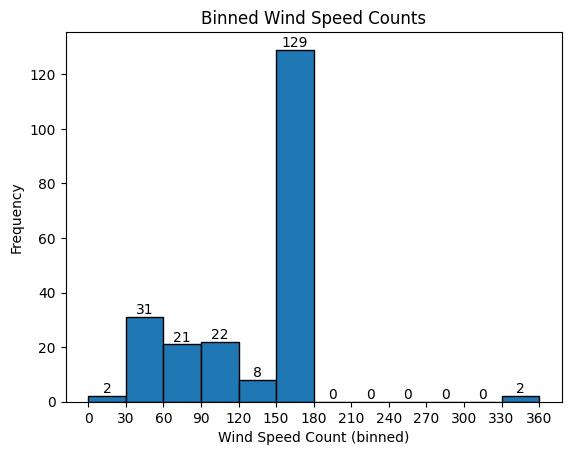

In [5]:
plt.bar(binned_counts[1][:-1], binned_counts[0], width=np.diff(binned_counts[1]), align="edge", edgecolor="black")
plt.title('Binned Wind Speed Counts')
plt.xlabel('Wind Speed Count (binned)')
plt.ylabel('Frequency')

# Add text labels on top of each bar
for i in range(len(binned_counts[0])):
    plt.text(binned_counts[1][i] + np.diff(binned_counts[1])[i] / 2,  # x-coordinate
             binned_counts[0][i],  # y-coordinate
             str(binned_counts[0][i]),
             ha='center', va='bottom')

plt.xticks(bin_edges)
plt.show()


Great! This tells exactly how many stations are in each bin of wind speed. Now we want to determine which stations have more of a bias in their PSPS probablity due to their limited amount of wind data.

To do this we want each station's wind data to be statistically significant in order to achieve at least a somewhat normal distirbution from the mean. To do this, the sample size typically must be greater than or equal to 30, therefore stations with a count of less than 30 will be chosen as having more of a bias in their PSPS due to limited data.

In [6]:
wind_speed_stats[wind_speed_stats['count']<30]

count       mean  median   min   max  25th percentile  \
station                                                          
CAB         24  17.333333    15.5  10.0  29.0             12.0   
NOE         14  13.214286    12.0   9.0  20.0             10.0   

         75th percentile  
station                   
CAB                22.25  
NOE                15.50

From this output, we can see that stations 'CAB' and 'NOE' both seem to have more bias in the PSPS probabilities due to their limited data.

#### Potential Solutions

To resolve this issue of low station counts, we can . . .
1. have a threshold that determines the minimum amount of data required to be used in the model.
2. exclude these stations.
3. get more data to satisfy the 30 count requirement.
4. use data from nearby weather stations.
5. synthetically generate data.
6. weigh the data by how much data it has (lower count --> lower weight).
7. use Bayesian methods to take uncertainty into account.

### Question 2
Anything interesting or challenging you encountered during the process or from looking at the results? Any ideas come to mind that maybe weren't part of the task at hand yet could be of interest?

#### Task 1
Calculate the PSPS Probability for each Weather Station.

Lets first take a look into the merged dataset for columns that may help with this task. We also want to see if there is a column that tells us if there was a PSPS or not which would serve to be helpful in determining the exact probability for PSPS event happening.

In [7]:
gdf_weatherstation_merged.columns

Index(['date', 'wind_speed', 'station', 'snapshot_date_x', 'vri', 'alert',
       'max_gust', '99th', '95th', 'snapshot_date_y', 'objectid',
       'weatherstationcode', 'weatherstationname', 'scadartuid', 'structureid',
       'nwszone', 'district', 'thomasbrospagegrid', 'constructionstatus',
       'creationuser', 'datecreated', 'datemodified', 'lastuser',
       'structureguid', 'symbolrotation', 'latitude', 'longitude', 'elevation',
       'twinguid', 'hftd', 'zone1idc', 'hftdidc', 'gdb_geomattr_data',
       'globalid', 'shape', 'shape_srid', 'snapshot_date', 'geometry'],
      dtype='object')

From these columns we cannot see whether or not a PSPS event happened. Because we don't have the exact probability, we can take the best guess. To do this, lets do heuristic (a pragmatic method not fully optimized or perfected) on whether a PSPS event occurred by taking into account the wind speed. We will set the threshold to be greater than or equal to **56mph** because under the [Tariff Revisions U902E](https://docs.cpuc.ca.gov/PublishedDocs/Efile/G000/M254/K255/254255760.PDF) that is the limit set to allow PSPSs.

In [8]:
wind_speed_counts = gdf_weatherstation_merged.groupby('station')['wind_speed'].agg([('count'), 
                                                                                    ('count_wind_56plus', lambda x: (x >= 56).sum()),
                                                                                   ])
wind_speed_counts['proportion_56plus'] = wind_speed_counts['count_wind_56plus'] / wind_speed_counts['count']
wind_speed_counts

count  count_wind_56plus  proportion_56plus
station                                             
AMO        166                  0           0.000000
ANE        179                  0           0.000000
ARH        179                  0           0.000000
AVO        179                  0           0.000000
AVY        116                  8           0.068966
...        ...                ...                ...
WST         61                  0           0.000000
WSY        176                 15           0.085227
WWY        179                  1           0.005587
WYN        178                  0           0.000000
YSA        179                  0           0.000000

[215 rows x 3 columns]

In [32]:
wind_speed_counts_sorted = wind_speed_counts.sort_values(by='proportion_56plus', ascending=False)
wind_speed_counts_sorted

count  count_wind_56plus  proportion_56plus
station                                             
SIL        177                 94           0.531073
HAU         49                 15           0.306122
EWR        142                 26           0.183099
HHC        171                 31           0.181287
CWD        172                 29           0.168605
...        ...                ...                ...
JAM        175                  0           0.000000
JUL        179                  0           0.000000
KCK        179                  0           0.000000
LCK        104                  0           0.000000
YSA        179                  0           0.000000

[215 rows x 3 columns]

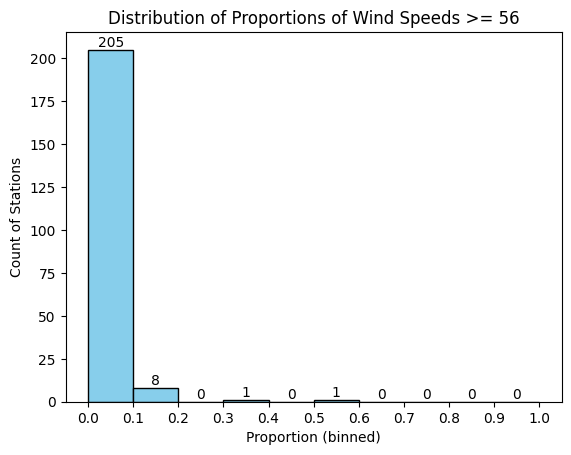

In [9]:
proportions = wind_speed_counts['proportion_56plus']

num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
binned_proportions = np.histogram(proportions, bins=bins)

plt.bar(binned_proportions[1][:-1], binned_proportions[0], width=np.diff(binned_proportions[1]), align="edge", edgecolor="black", color='skyblue')

for i in range(len(binned_proportions[0])):
    plt.text(binned_proportions[1][i] + np.diff(binned_proportions[1])[i] / 2,  # x-coordinate
             binned_proportions[0][i],  # y-coordinate
             str(binned_proportions[0][i]),  # Count value
             ha='center', va='bottom')

# Set plot title and axis labels
plt.title('Distribution of Proportions of Wind Speeds >= 56')
plt.xlabel('Proportion (binned)')
plt.ylabel('Count of Stations')

# Set x-ticks to match bin edges for clarity
plt.xticks(bins)

# Show the plot
plt.show()

**Analysis**

From this graph we can see that the large majority of each stations proportion lie within 0.0 and 0.1, 8 between 0.1 and 0.2, 1 between 0.1 and 0.4, and 1 between 0.5 and 0.6.

We know that 'CAB and 'NOE' lie in the first bar between 0.0 and 0.1 beacause they have max wind speeds of 29.0 and 20.0 respectively. This means neither have a wind speed greater than or equal to 56 resulting in their proportions being both 0.0.

In [10]:
gdf_weatherstation_merged['avg_wind_speed'] = gdf_weatherstation_merged.groupby('station')['wind_speed'].transform('mean')
heat_data = gdf_weatherstation_merged[['latitude', 'longitude', 'avg_wind_speed']].dropna()
heat_data

latitude   longitude  avg_wind_speed
0      33.357121 -117.276505       19.096386
1      33.357121 -117.276505       19.096386
2      33.357121 -117.276505       19.096386
3      33.357121 -117.276505       19.096386
4      33.357121 -117.276505       19.096386
...          ...         ...             ...
38838  33.113150 -116.671680       30.888268
38839  33.113150 -116.671680       30.888268
38840  33.113150 -116.671680       30.888268
38841  33.113150 -116.671680       30.888268
38842  33.113150 -116.671680       30.888268

[38843 rows x 3 columns]

In [11]:
location_mean_coordinates = [gdf_weatherstation.geometry.y.mean(), gdf_weatherstation.geometry.x.mean()]
m = folium.Map(location=location_mean_coordinates, zoom_start=9)

HeatMap(heat_data, 
        radius=22,
        max_zoom=13,
        blur=15,
        min_opacity=0.1
       ).add_to(m)
display(m)

Having difficulty creating heatmapwithtime. I believe the time needs to be sequential in order to work and since the data we have is seemingly taken at random, there are problems creating the map overlay.

In [12]:
# heat_time_data = gdf_weatherstation_merged[['latitude', 'longitude', 'wind_speed', 'date']].dropna()
# heat_time_data['date'] = pd.to_datetime(heat_time_data['date'])
# heat_time_data


# m = folium.Map(location=[heat_time_data['latitude'].mean(), heat_time_data['longitude'].mean()], zoom_start=6)

# heatmap_time_data = [
#     [[row['latitude'], row['longitude'], row['wind_speed']] for _, row in group.iterrows()]
#     for _, group in time_grouped_data
# ]

# # Add a HeatMapWithTime layer
# HeatMapWithTime(
#     heatmap_time_data,  # Data grouped by time intervals
#     radius=10,  # Adjust radius as needed
#     auto_play=True,  # Automatically play the time-based animation
#     max_opacity=0.6,  # Adjust opacity for better visualization
#     min_opacity=0.2,  # Minimum opacity
#     speed_step=0.1  # Speed of the playback (adjustable)
# ).add_to(m)
# display(m)

Awesome 😁 now lets see a heatmap of the proportions greater than 56

In [13]:
gdf_weatherstation_merged['proportion_56plus'] = (
    gdf_weatherstation_merged.groupby('station')['wind_speed']
    .transform(lambda x: (x >= 56).sum() / len(x))
)

proportion_data = gdf_weatherstation_merged[['latitude', 'longitude', 'proportion_56plus']].dropna()
proportion_data


latitude   longitude  proportion_56plus
0      33.357121 -117.276505                0.0
1      33.357121 -117.276505                0.0
2      33.357121 -117.276505                0.0
3      33.357121 -117.276505                0.0
4      33.357121 -117.276505                0.0
...          ...         ...                ...
38838  33.113150 -116.671680                0.0
38839  33.113150 -116.671680                0.0
38840  33.113150 -116.671680                0.0
38841  33.113150 -116.671680                0.0
38842  33.113150 -116.671680                0.0

[38843 rows x 3 columns]

In [14]:
heat_data

latitude   longitude  avg_wind_speed
0      33.357121 -117.276505       19.096386
1      33.357121 -117.276505       19.096386
2      33.357121 -117.276505       19.096386
3      33.357121 -117.276505       19.096386
4      33.357121 -117.276505       19.096386
...          ...         ...             ...
38838  33.113150 -116.671680       30.888268
38839  33.113150 -116.671680       30.888268
38840  33.113150 -116.671680       30.888268
38841  33.113150 -116.671680       30.888268
38842  33.113150 -116.671680       30.888268

[38843 rows x 3 columns]

In [15]:
m = folium.Map(location=location_mean_coordinates, zoom_start=9)

HeatMap(proportion_data, 
        radius=22,
        max_zoom=13,
        blur=15,
        min_opacity=0.1
       ).add_to(m)
display(m)

**Analysis**<br>
From this heat map of the proportion of wind speeds greater than 56, we can see that there is a point that sticks out in bright red located right in the Cleveland National Forest. This map is potentially more telling than the previous map created because this tells us how often the wind speeds are above 56 rather than their mean wind speed. It provides better insight as to which areas are significant and have continuously high wind speeds. 

In [16]:
gdf_weatherstation_merged.columns

Index(['date', 'wind_speed', 'station', 'snapshot_date_x', 'vri', 'alert',
       'max_gust', '99th', '95th', 'snapshot_date_y', 'objectid',
       'weatherstationcode', 'weatherstationname', 'scadartuid', 'structureid',
       'nwszone', 'district', 'thomasbrospagegrid', 'constructionstatus',
       'creationuser', 'datecreated', 'datemodified', 'lastuser',
       'structureguid', 'symbolrotation', 'latitude', 'longitude', 'elevation',
       'twinguid', 'hftd', 'zone1idc', 'hftdidc', 'gdb_geomattr_data',
       'globalid', 'shape', 'shape_srid', 'snapshot_date', 'geometry',
       'avg_wind_speed', 'proportion_56plus'],
      dtype='object')

In [31]:
layered_m = folium.Map(location=location_mean_coordinates, zoom_start=9)

folium.FeatureGroup(name="Proportion 56+ Wind Speed").add_child(
    HeatMap(proportion_data, 
            radius=22, 
            max_zoom=13, 
            blur=15, 
            min_opacity=0.1)
).add_to(layered_m)

# add wind data
gust_data = gdf_weatherstation_merged[['latitude', 'longitude', 'max_gust']].dropna()
folium.FeatureGroup(name="Max Gust Speed").add_child(
    HeatMap(gust_data, 
            radius=22, 
            max_zoom=13, 
            blur=15, 
            min_opacity=0.1, 
            gradient={0.2: 'purple', 0.4: 'pink', 0.6: 'yellow', 0.8: 'red'})
).add_to(layered_m)

# add vegetation risk data
vri_numeric = {'H': 1.0, 'M': 0.5, 'L': 0.1}
gdf_weatherstation_merged['vri_numeric'] = gdf_weatherstation_merged['vri'].map(vri_numeric)
vri_data = gdf_weatherstation_merged[['latitude', 'longitude', 'vri_numeric']].dropna()
folium.FeatureGroup(name="VRI").add_child(
    HeatMap(vri_data, 
            radius=22, 
            max_zoom=13, 
            blur=15, 
            min_opacity=0.1, 
            gradient = {1.0: 'brown', 0.5: 'olive', 0.1: 'green'})
).add_to(layered_m)

# add construction status data
construction_numeric = {'A': 1.0, 'P': 0.5, 'R': 0.1}
gdf_weatherstation_merged['constructionstatus_numeric'] = gdf_weatherstation_merged['constructionstatus'].map(construction_numeric)
construction_data = gdf_weatherstation_merged[['latitude', 'longitude', 'constructionstatus_numeric']].dropna()
folium.FeatureGroup(name="Construction Status").add_child(
    HeatMap(construction_data, 
            radius=22, 
            max_zoom=13, 
            blur=15, 
            min_opacity=0.1, 
            gradient = {1.0: 'orange', 0.5: 'yellow', 0.1: 'blue'})
).add_to(layered_m)

# add alerts data
alert_data = gdf_weatherstation_merged[['latitude', 'longitude', 'alert']].dropna()
folium.FeatureGroup(name="Alert Levels").add_child(
    HeatMap(alert_data, 
            radius=22, 
            max_zoom=13, 
            blur=15, 
            min_opacity=0.1)
).add_to(layered_m)


folium.LayerControl().add_to(layered_m)

layered_m

In [30]:
gdf_weatherstation_merged['alert'].unique()

<function ndarray.sort>